## Show distribution of structure prediction performance

Reuse same format as the algo_benchmark plot of Figure 1.

Add our algorithm and hopefully show less performance gap

**Assigned to**: Alberic

Use Ploty, and a white background

In [26]:
import pandas as pd
from rouskinhf import get_dataset
import torch
import numpy as np

In [25]:
def compute_f1(pred_matrix, target_matrix, threshold=0.5):
    """
    Compute the F1 score of the predictions.

    :param pred_matrix: Predicted pairing matrix probability  (L,L)
    :param target_matrix: True binary pairing matrix (L,L)
    :return: F1 score for this RNA structure
    """

    pred_matrix = (pred_matrix > threshold).float()

    sum_pair = torch.sum(pred_matrix) + torch.sum(target_matrix)

    if sum_pair == 0:
        return 1.0
    else:
        return (2 * torch.sum(pred_matrix * target_matrix) / sum_pair).item()
    
def pairList2pairMatrix(pair_list, len_seq):
    pair_list = np.array(pair_list).astype(int)
    pairing_matrix = torch.zeros((len_seq, len_seq))

    if len(pair_list) > 0:
        pairing_matrix[pair_list[:,0], pair_list[:,1]] = 1.0
        pairing_matrix[pair_list[:,1], pair_list[:,0]] = 1.0

    return pairing_matrix

In [7]:
ground_truth = pd.DataFrame()

for test_set in ["PDB", "lncRNA", "viral_fragments"]:
    data = get_dataset(test_set, force_download=True)
    data = pd.DataFrame(data).T[['sequence', 'structure']]
    data['dataset'] = test_set

    ground_truth = pd.concat([ground_truth, data])
    del data

PDB: Downloading dataset from HuggingFace Hub...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

PDB: Download complete. File saved at data/PDB/data.json
lncRNA: Downloading dataset from HuggingFace Hub...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

lncRNA: Download complete. File saved at data/lncRNA/data.json
viral_fragments: Downloading dataset from HuggingFace Hub...


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

viral_fragments: Download complete. File saved at data/viral_fragments/data.json


In [59]:
data_comparison = pd.DataFrame()

for model in ['PT', 'PT+FT']:

    prediction = pd.read_feather(f'data/test_results_{model}.feather')

    merged = ground_truth.reset_index().rename(columns={'index': 'reference'}).merge(prediction, on=['sequence', 'reference'], suffixes=('_true', '_pred'))

    f1s = []
    for i, row in merged.iterrows():
        f1s.append(compute_f1(torch.tensor(np.stack(row['structure_pred'])), 
                            pairList2pairMatrix(row['structure_true'], len(row['sequence']))))

    merged['f1'] = f1s
    merged['model'] = model
    print(merged.groupby('dataset')['f1'].mean())

    data_comparison = pd.concat([data_comparison, merged[['reference', 'sequence', 'model', 'dataset', 'f1']]])

dataset
PDB                0.828023
lncRNA             0.076437
viral_fragments    0.499693
Name: f1, dtype: float64
dataset
PDB                0.870385
lncRNA             0.105360
viral_fragments    0.541010
Name: f1, dtype: float64


In [60]:
import plotly.express as px

px.violin(data_comparison, x="dataset", y="f1", color="model", points=None, box=True, title="F1 score on test sets", template="plotly_white", width=1000, height=400)



In [61]:
# Creat a box plot with plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

colors = px.colors.qualitative.D3
for i, model in enumerate(['PT', 'PT+FT']):
    results_dataset = data_comparison[data_comparison['model']==model]
    fig.add_trace(go.Violin(x=results_dataset['dataset'], y=results_dataset['f1'], 
                            name=model, marker_color=colors[i], 
                            meanline_visible=True, points=False))
    
fig.update_layout(title='F1 score on test sets for pretraining vs pretraining + fine-tuning models', 
                  violinmode='group', yaxis_range=[0, 1],
                  width=1000, height=400,
                  template='plotly_white', font_size=15, font_color='black',)
# fig.update_xaxes(categoryorder='array', categoryarray= ['RNAstructure', 'EternaFold', 'MXFold2', 'UFold'])
fig.show()

In [ ]:
for dataset in ['PDB', 'lncRNA', 'viral_fragments']:

    data = data_comparison[data_comparison['dataset']==dataset]

In [99]:
compare_f1 = data_comparison[data_comparison['model']=='PT'].merge(data_comparison[data_comparison['model']=='PT+FT'], on=['reference', 'sequence', 'dataset'], suffixes=('_PT', '_PT+FT'))[['dataset', 'f1_PT', 'f1_PT+FT']]
compare_f1['isBetter'] = compare_f1['f1_PT+FT'] >= compare_f1['f1_PT']
compare_f1

,dataset,f1_PT,f1_PT+FT,isBetter
0,PDB,0.705882,0.625000,False
1,PDB,0.803922,0.811881,True
2,PDB,0.956522,0.956522,True
3,PDB,0.909091,1.000000,True
4,PDB,0.842105,0.888889,True
...,...,...,...,...
424,viral_fragments,0.237726,0.284024,True
425,viral_fragments,0.516129,0.631111,True
426,viral_fragments,0.311111,0.369478,True
427,viral_fragments,0.353591,0.482759,True


In [103]:
from plotly.subplots import make_subplots

compare_f1 = data_comparison[data_comparison['model']=='PT'].merge(data_comparison[data_comparison['model']=='PT+FT'], on=['reference', 'sequence', 'dataset'], suffixes=('_PT', '_PT+FT'))[['dataset', 'f1_PT', 'f1_PT+FT']]
compare_f1['isBetter'] = compare_f1['f1_PT+FT'] >= compare_f1['f1_PT']

fig = make_subplots(rows=1, cols=3, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=[ f'{dataset} ({100*compare_f1[compare_f1["dataset"]==dataset]["isBetter"].sum()/sum(compare_f1["dataset"]==dataset):.1f}% ≥ y=x)' for dataset in compare_f1['dataset'].unique()],
                    x_title='F1 score for PT', y_title='F1 score for PT+FT')

colors = px.colors.qualitative.D3
for i, dataset in enumerate(compare_f1['dataset'].unique()):

    data = data_comparison[data_comparison['dataset']==dataset]

    fig.add_trace(go.Scatter(x=data[data['model']=='PT']['f1'],
                        y=data[data['model']=='PT+FT']['f1'],
                        mode='markers', 
                        marker_color=colors[0], opacity=0.8, showlegend=False,
                        name=dataset), row=1, col=i+1)
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line_color='black', line_dash='dash', showlegend=False), row=1, col=i+1)


fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )

fig.update_layout(width=1200, height=450, template='plotly_white', font_size=15, font_color='black',
                  title='F1 score comparison per sequence for pretraining vs pretraining + fine-tuning models')
fig.show()

<AxesSubplot: >

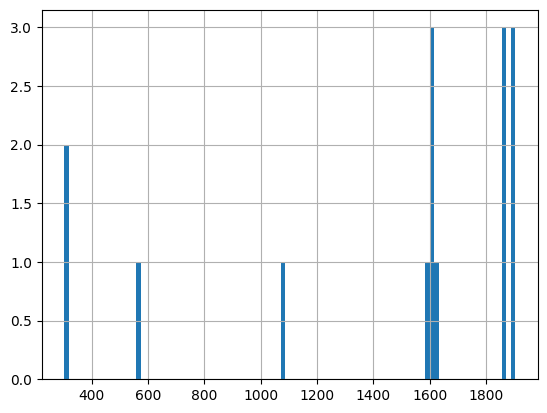

In [58]:
ground_truth[ground_truth['dataset']=='lncRNA'].sequence.apply(len).hist(bins=100)